<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_Stateful_RNN__Forecasting_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
def plot_series(time, series, format='', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  """ this is an arbitrary pattern that we can change"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """ repeats the same pattern each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.rand(len(time)) * noise_level

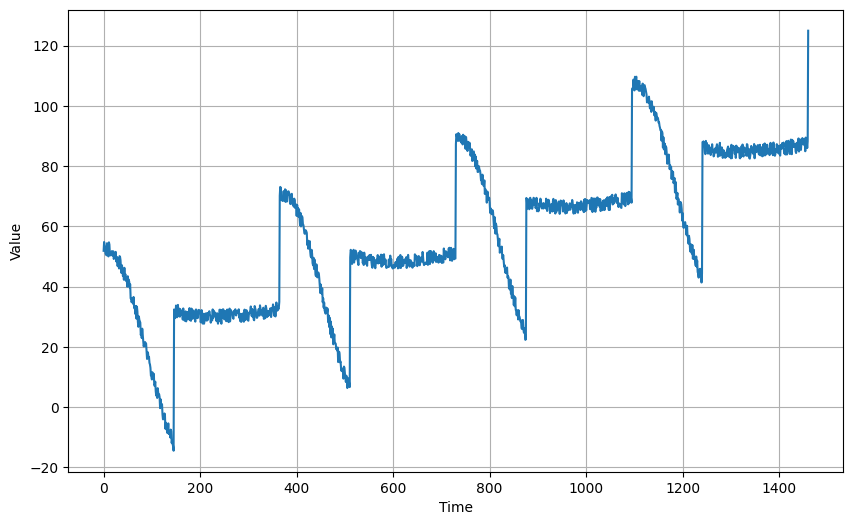

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# stateful rnn forecasting

def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size +1))
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  return ds.batch(1).prefetch(1)

In [ ]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
  print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                           batch_input_shape=[1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 6s 53ms/step - loss: 369.9595 - mae: 370.4594 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 324.7112 - mae: 325.2111 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 1s 23ms/step - loss: 273.2146 - mae: 273.7146 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 220.9524 - mae: 221.4524 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 1s 23ms/step - loss: 170.1565 - mae: 170.6565 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 1s 42ms/step - loss: 119.0787 - mae: 119.5787 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 42ms/step - loss: 64.5675 - mae: 65.0675 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 1s 23ms/step - loss: 21.4246 - mae: 21.9137 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 1s 25ms/step - loss: 17

(1e-08, 0.0001, 0.0, 30.0)

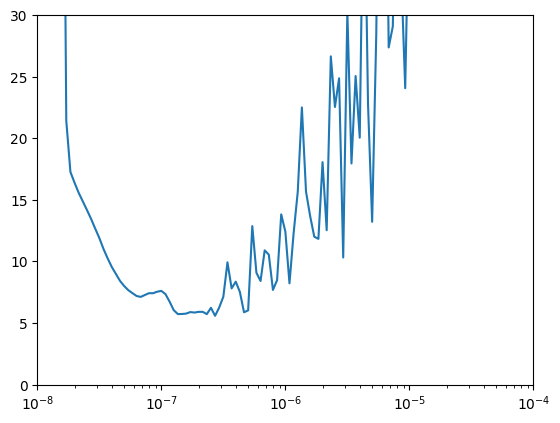

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                           batch_input_shape=[1, None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'my_checkpoint.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 31ms/step - loss: 175.1500 - mae: 175.6500 - val_loss: 66.7761 - val_mae: 67.2761
Epoch 2/500
33/33 [==============================] - 0s 15ms/step - loss: 21.4819 - mae: 21.9765 - val_loss: 17.3432 - val_mae: 17.8409
Epoch 3/500
33/33 [==============================] - 0s 15ms/step - loss: 14.9327 - mae: 15.4175 - val_loss: 10.2601 - val_mae: 10.7412
Epoch 4/500
33/33 [==============================] - 1s 15ms/step - loss: 12.5055 - mae: 12.9834 - val_loss: 8.7355 - val_mae: 9.2285
Epoch 5/500
33/33 [==============================] - 0s 15ms/step - loss: 11.5411 - mae: 12.0126 - val_loss: 8.3282 - val_mae: 8.8181
Epoch 6/500
33/33 [==============================] - 1s 15ms/step - loss: 10.4955 - mae: 10.9665 - val_loss: 8.6535 - val_mae: 9.1389
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 9.6728 - mae: 10.1403 - val_loss: 9.2240 - val_mae: 9.7077
Epoch 8/500
33/33 [==============================] - 1s

In [ ]:
# load the best model
model = keras.models.load_model('my_checkpoint.h5')

In [ ]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1:-1, 0]

1/1 [==============================] - 1s 784ms/step


In [ ]:
rnn_forecast.shape

(461,)

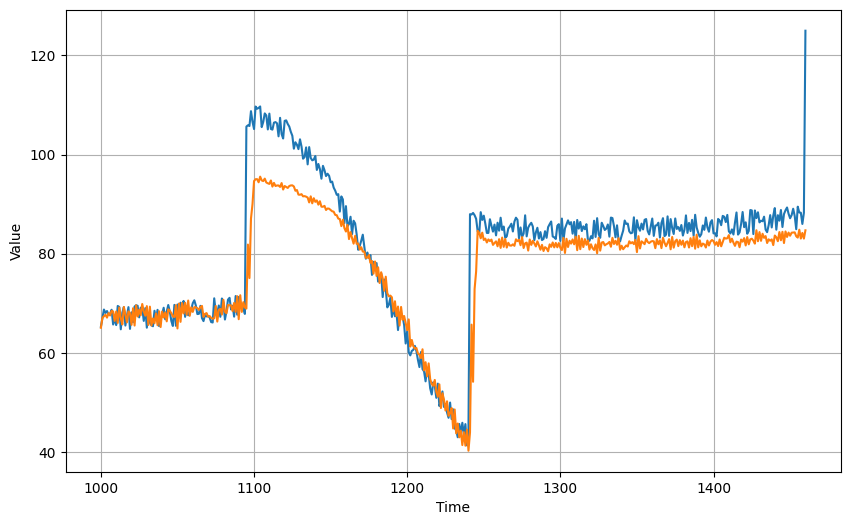

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.054748